In [2]:
import time
from datetime import datetime
import vectorbt as vbt

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

### Stochastic Osillator
- อธิบายส่วนประกอบ indicator
    - %K มีค่า 0-100
    - %D คือ moving average ของ %K
    - smooth_k ไว้ถ่วงน้ำหนัก %K
    - %K > 80 คือ overbought
    - %K < 20 คือ oversold
- ตัวอย่างใช้งาน
    - ใช้งานหาจุดย่อ
    - เข้าเมื่อราคา overbought/oversold
    - เข้าเมื่อราคา overbought/oversold แล้วกลับมาในช่วงปกติ
    - เข้าเมื่อ %K และ %D ตัดกันในช่วง overbought/oversold
    - ใช้กับกราฟมีเทรน
    - ใช้กับกราฟเสียเทรน
    - ใช้กับกราฟ sideway
    - divergence
- เปรียบเทียบจุดแข็งจุดอ่อน
- วิธีแก้ไข

##### ที่มา

https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/stochastic-oscillator/

https://fbs.com/analytics/guidebooks/stochastic-49

https://knowledge.bualuang.co.th/knowledge-base/stochastic-oscillator/

https://admiralmarkets.sc/th/education/articles/forex-indicators/trading-stochastic-oscillator

https://www.lucid-trader.com/stochastic-oscillator/

In [110]:
data = pd.read_csv('../MyStrategy/GBPUSD_1h.csv')
data.tail()

,timestamp,open,high,low,close,adj close,volumn
5011,2022-08-30 13:00:00+01:00,1.171921,1.172044,1.169098,1.170029,1.170029,0
5012,2022-08-30 14:00:00+01:00,1.169892,1.171921,1.169180,1.169905,1.169905,0
5013,2022-08-30 15:00:00+01:00,1.168484,1.168484,1.162372,1.162926,1.162926,0
5014,2022-08-30 16:00:00+01:00,1.163399,1.167174,1.163399,1.165189,1.165189,0
5015,2022-08-30 17:00:00+01:00,1.165365,1.166521,1.164985,1.165189,1.165189,0


In [111]:
df = data.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
df.set_index('timestamp', inplace = True)
df

,open,high,low,close,adj close,volumn
timestamp,,,,,,
2021-11-04 17:00:00,1.349364,1.349437,1.348418,1.349273,1.349273,0
2021-11-04 18:00:00,1.349382,1.350366,1.349091,1.349655,1.349655,0
2021-11-04 19:00:00,1.349509,1.350475,1.349509,1.350238,1.350238,0
2021-11-04 20:00:00,1.350311,1.350457,1.349509,1.350020,1.350020,0
2021-11-04 21:00:00,1.349692,1.350202,1.348745,1.350074,1.350074,0
...,...,...,...,...,...,...
2022-08-30 12:00:00,1.171921,1.172044,1.169098,1.170029,1.170029,0
2022-08-30 13:00:00,1.169892,1.171921,1.169180,1.169905,1.169905,0
2022-08-30 14:00:00,1.168484,1.168484,1.162372,1.162926,1.162926,0


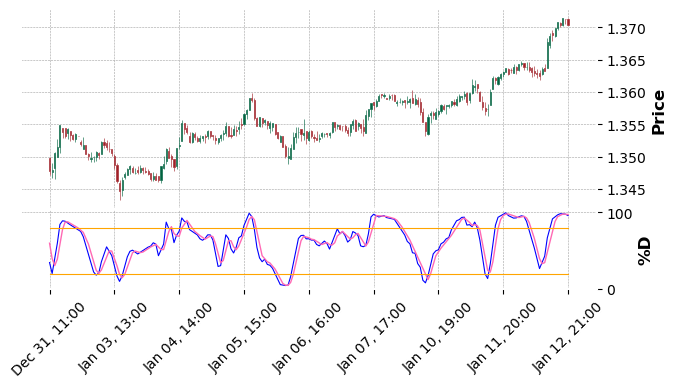

In [112]:
df.ta.stoch(14, append=True) # default k=14, d=3, smooth_k=3
df['prev_k'] = df['STOCHk_14_3_3'].shift(1)
df['prev_d'] = df['STOCHd_14_3_3'].shift(1)
df['d_cross'] = (df['prev_k'] > df['prev_d']) & (df['STOCHk_14_3_3'] < df['STOCHd_14_3_3'])
df['k_cross'] = (df['prev_k'] < df['prev_d']) & (df['STOCHk_14_3_3'] > df['STOCHd_14_3_3']) 

start_date, end_date = '2021-12-31 10:45:00', '2022-01-12 21:45:00'

stoch_k = df['STOCHk_14_3_3'].loc[start_date: end_date]
stoch_d = df['STOCHd_14_3_3'].loc[start_date: end_date]
df_plot = df.loc[start_date: end_date]

overbought = np.empty(df_plot.shape[0])
overbought.fill(80)
oversold = np.empty(df_plot.shape[0])
oversold.fill(20)

k_plot = mpf.make_addplot(stoch_k, panel=1, color='blue', width=0.8, ylabel='%K')
d_plot = mpf.make_addplot(stoch_d, panel=1, color='hotpink', width=1, ylabel='%D')
overbought_plot = mpf.make_addplot(overbought, panel=1, color='orange', width=0.8)
oversold_plot = mpf.make_addplot(oversold, panel=1, color='orange', width=0.8)

mpf.plot(df_plot, type='candle', style='charles',
         addplot=[k_plot, d_plot, overbought_plot, oversold_plot],
         figsize=(8, 4))

In [113]:
# - เข้าเมื่อราคา overbought/oversold
# - เข้าเมื่อราคา overbought/oversold แล้วกลับมาในช่วงปกติ
# - เข้าเมื่อ %K และ %D ตัดกันในช่วง overbought/oversold
# แบบไหนได้ราคาสูงสุด ต่ำสุด ? ถ้าเข้าที่ open ค่า stoch k=14, d=3, smooth_k=3

def find_peak_price(df, entry_type='open'):
    entry_data = dict(entry_start=[0, 0], entry_end=[0, 0], entry_cross=[0, 0])
    start_index = 0
    end_index = 0
    current_min_prices = [np.Inf, np.Inf, np.Inf]
    current_max_prices = [np.NINF, np.NINF, np.NINF]
    is_crossed = False
    df_status = 'idle'

    for index, row in df.iterrows():
        if df_status == 'idle':
            if row['STOCHk_14_3_3'] > 80:
                df_status = 'overbought'
                current_max_prices[0] = row[entry_type]

            elif row['STOCHk_14_3_3'] < 20:
                df_status = 'oversold'
                current_min_prices[0] = row[entry_type]

        if df_status == 'overbought':
            if row['d_cross'] == True and is_crossed == False:
                is_crossed = True
                current_max_prices[1] = row[entry_type]

            if row['STOCHk_14_3_3'] < 80:
                df_status = 'idle'
                is_crossed = False
                current_max_prices[2] = row[entry_type]

                max_item = max(current_max_prices)
                index_list = [index for index in range(len(current_max_prices)) if current_max_prices[index] == max_item]
                # print(index_list)
                for i in index_list:
                    if i == 0:
                        entry_data['entry_start'][0] = entry_data['entry_start'][0] + 1
                    elif i == 1:
                        entry_data['entry_cross'][0] = entry_data['entry_cross'][0] + 1
                    elif i == 2:
                        entry_data['entry_end'][0] = entry_data['entry_end'][0] + 1
                # print('max: ', max_item, current_max_prices.index(max_item))
                current_max_prices = [np.NINF, np.NINF, np.NINF]

        if df_status == 'oversold':
            if row['k_cross'] == True and is_crossed == False:
                is_crossed = True
                current_min_prices[1] = row[entry_type]

            if row['STOCHk_14_3_3'] > 20:
                df_status = 'idle'
                is_crossed = False
                current_min_prices[2] = row[entry_type]

                min_item = min(current_min_prices)
                index_list = [index for index in range(len(current_min_prices)) if current_min_prices[index] == min_item]
                # print(index_list)
                for i in index_list:
                    if i == 0:
                        entry_data['entry_start'][1] = entry_data['entry_start'][1] + 1
                    elif i == 1:
                        entry_data['entry_cross'][1] = entry_data['entry_cross'][1] + 1
                    elif i == 2:
                        entry_data['entry_end'][1] = entry_data['entry_end'][1] + 1
                # print('min: ', min_item, current_min_prices.index(min_item))
                current_min_prices = [np.Inf, np.Inf, np.Inf]

    return [entry_data['entry_start'], entry_data['entry_end'], entry_data['entry_cross']]


In [114]:
open_peak_prices = find_peak_price(df.copy())
bar = vbt.plotting.Bar(
    data=open_peak_prices,
    trace_names=['overbought', 'oversold'],
    x_labels=['entry start', 'entry end', '%K %D cross']
)
bar.fig


FigureWidget({
    'data': [{'name': 'overbought',
              'showlegend': True,
              'type': 'ba…

In [115]:
close_peak_prices = find_peak_price(df.copy(), entry_type='close')
bar = vbt.plotting.Bar(
    data=close_peak_prices,
    trace_names=['overbought', 'oversold'],
    x_labels=['entry start', 'entry end', '%K %D cross']
)
bar.fig

FigureWidget({
    'data': [{'name': 'overbought',
              'showlegend': True,
              'type': 'ba…

In [129]:
def stoch_plot(df, start, end, plot_cross=True):
    df_plot = df.iloc[start: end]
    stoch_k = df_plot['STOCHk_14_3_3']
    stoch_d = df_plot['STOCHd_14_3_3']

    overbought = np.empty(df_plot.shape[0])
    overbought.fill(80)
    oversold = np.empty(df_plot.shape[0])
    oversold.fill(20)

    k_plot = mpf.make_addplot(stoch_k, panel=1, color='blue', width=0.8, ylabel='%K')
    d_plot = mpf.make_addplot(stoch_d, panel=1, color='hotpink', width=1, ylabel='%D')
    overbought_plot = mpf.make_addplot(overbought, panel=1, color='orange', width=0.8)
    oversold_plot = mpf.make_addplot(oversold, panel=1, color='orange', width=0.8)

    if plot_cross == False:
        return [k_plot, d_plot, overbought_plot, oversold_plot]

    up_markers = []
    down_markers = []

    for index, row in df_plot.iterrows():
        d_cross = row['d_cross']
        k_cross = row['k_cross']
        if k_cross == True and row['STOCHk_14_3_3'] < 20:
            up_markers.append(row['low'] * 0.998)
            down_markers.append(np.nan)
        elif d_cross == True and row['STOCHk_14_3_3'] > 80:
            up_markers.append(np.nan)
            down_markers.append(row['high'] * 1.002)
        else:
            up_markers.append(np.nan)
            down_markers.append(np.nan)

    up_plot = mpf.make_addplot(up_markers, type='scatter', marker='^', markersize=10, panel=0, color='red')
    down_plot = mpf.make_addplot(down_markers, type='scatter', marker='v', markersize=10, panel=0, color='green')

    return [k_plot, d_plot, overbought_plot, oversold_plot, up_plot, down_plot]

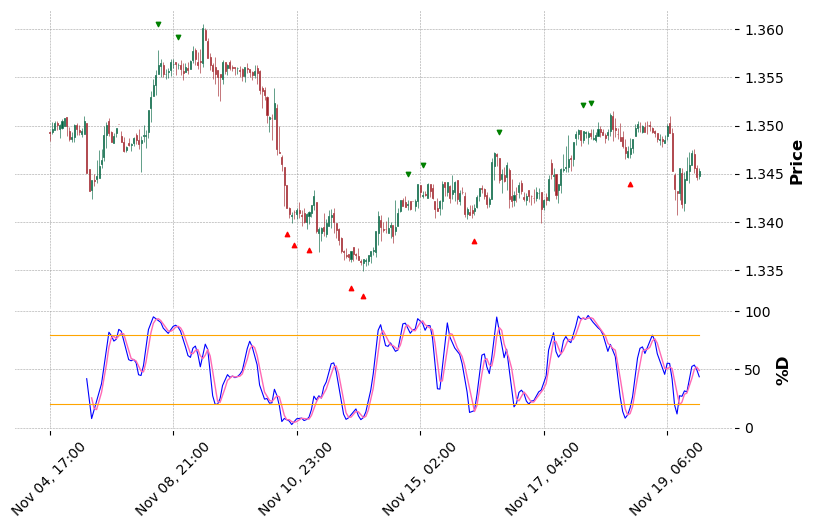

In [132]:
stoch_info_plots = stoch_plot(df, 0, 264)

mpf.plot(df.iloc[0:264], type='candle', style='charles',
         addplot=stoch_info_plots,
         figsize=(10, 6))

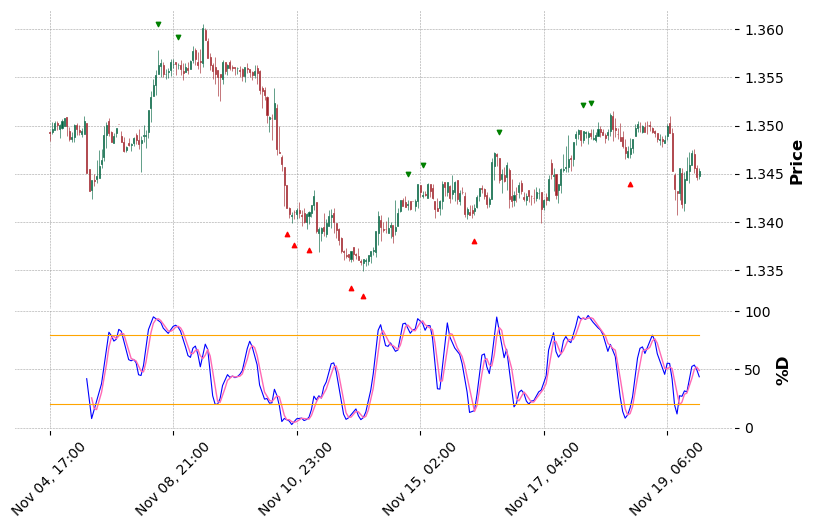

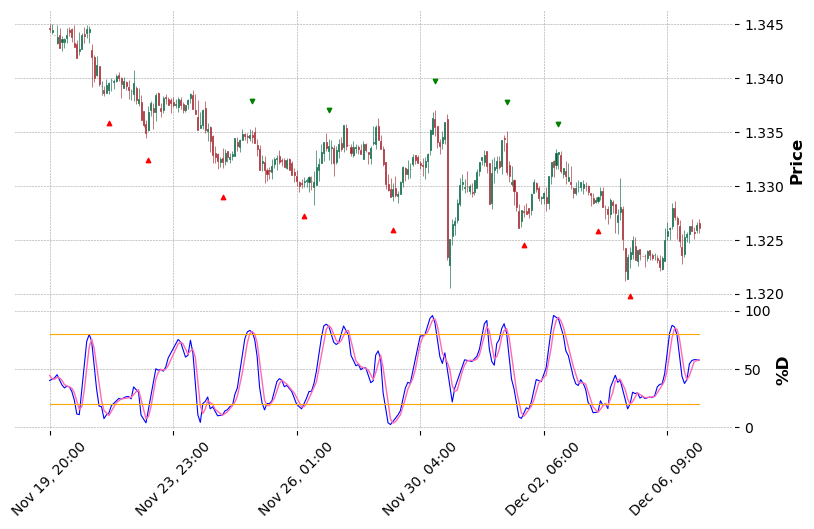

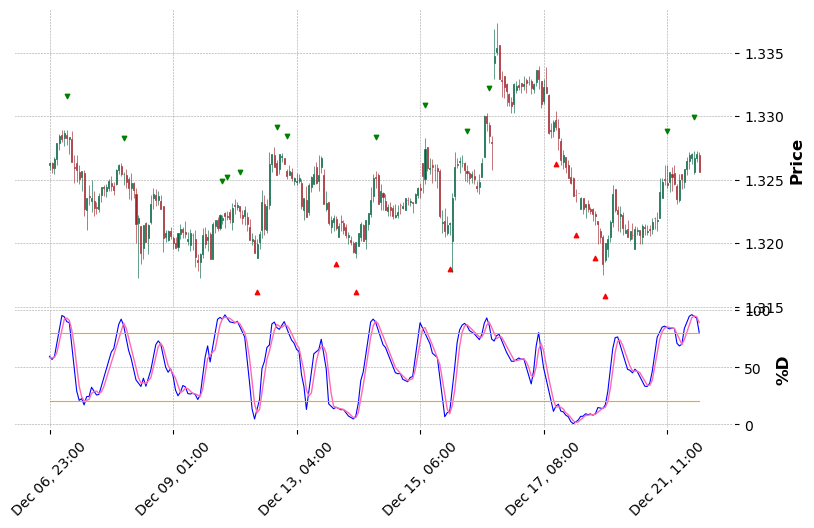

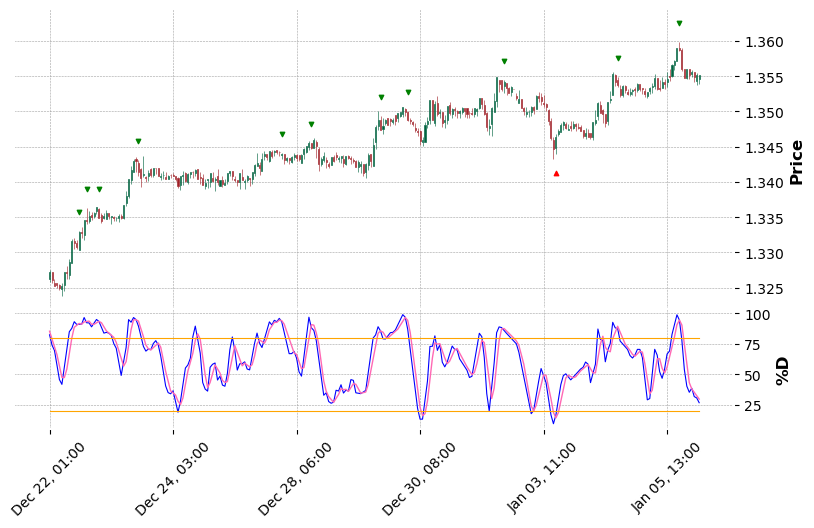

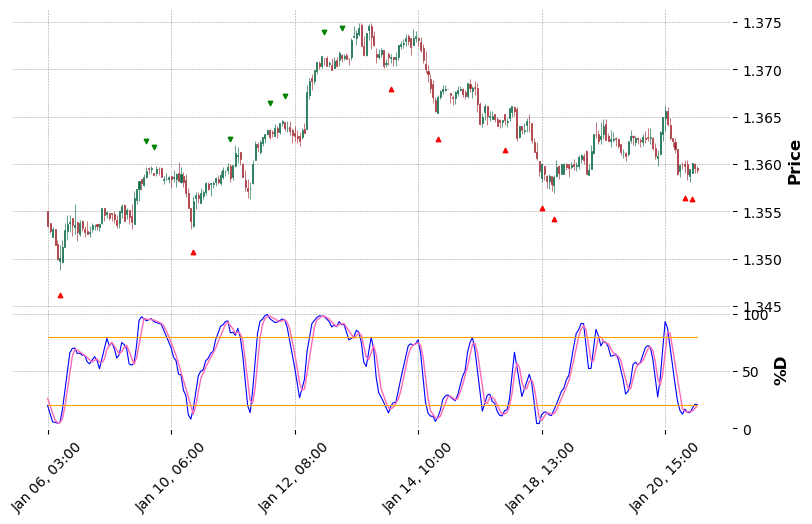

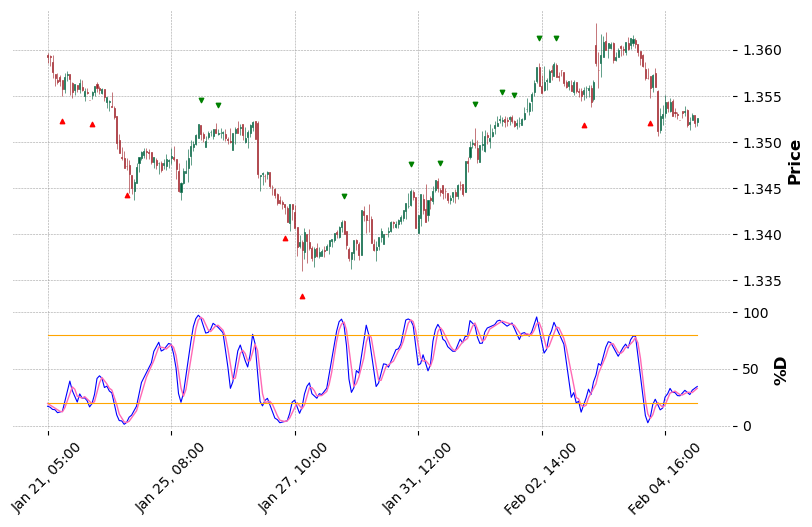

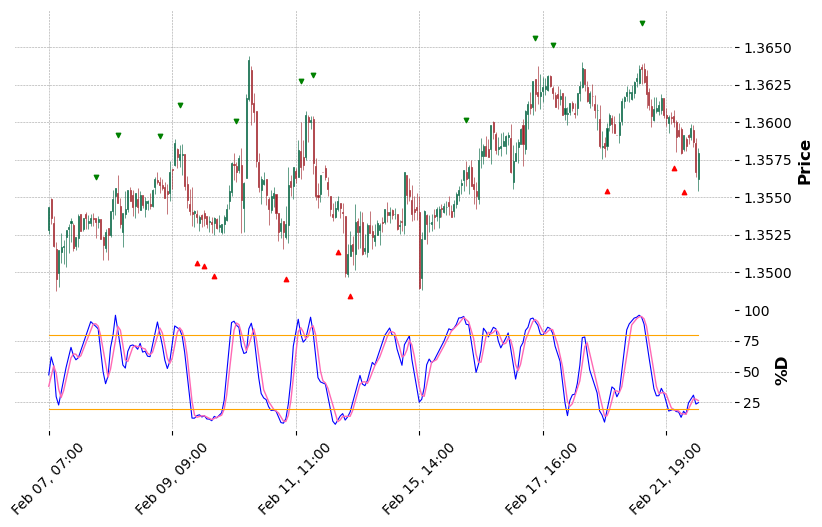

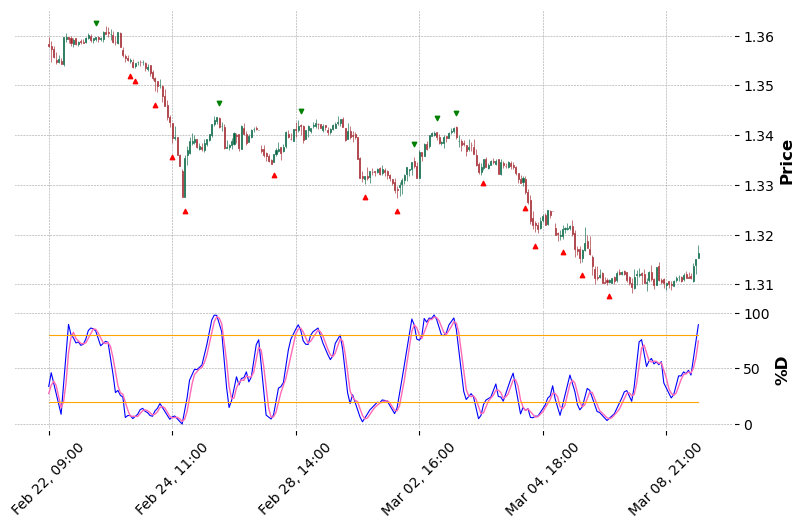

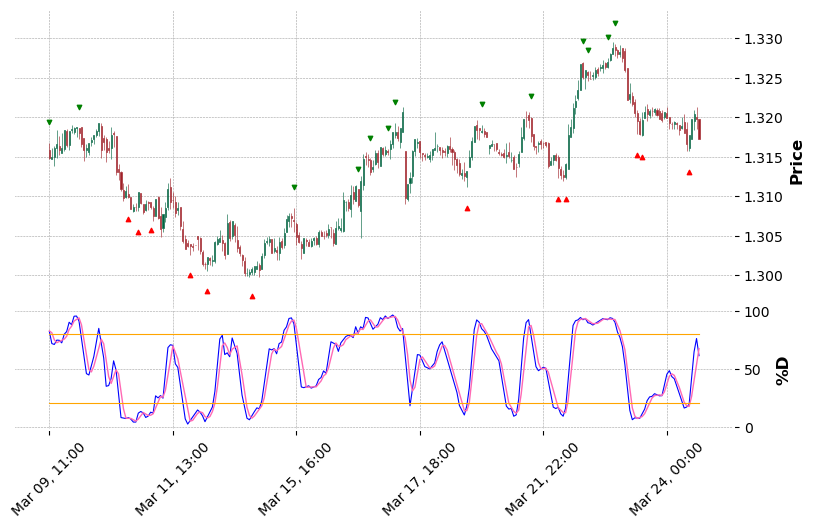

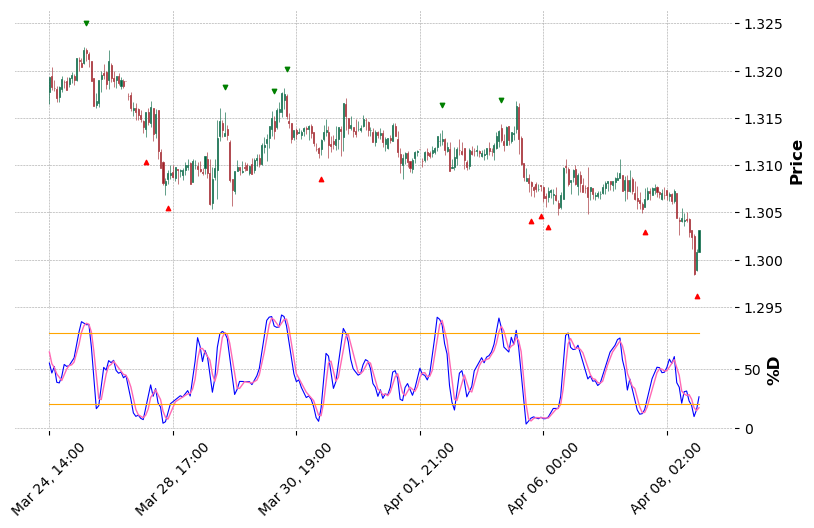

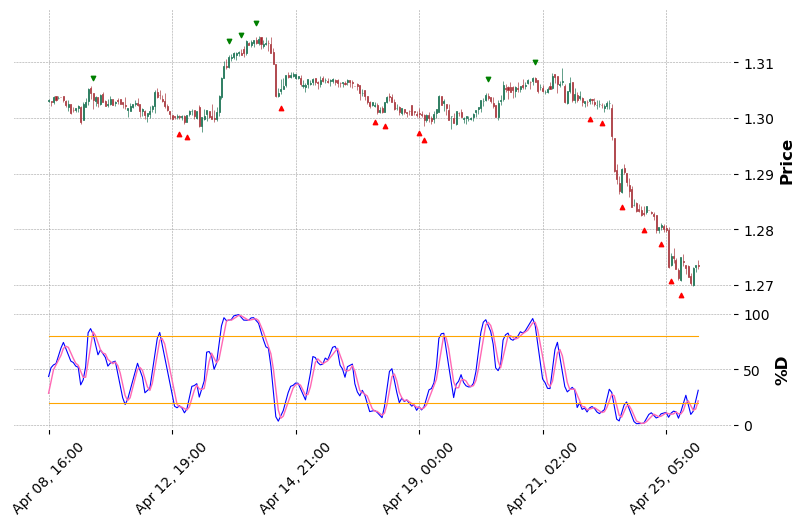

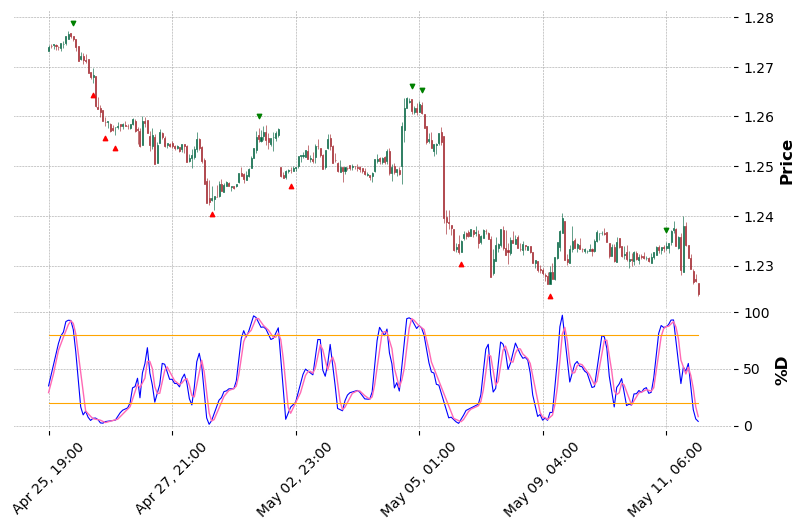

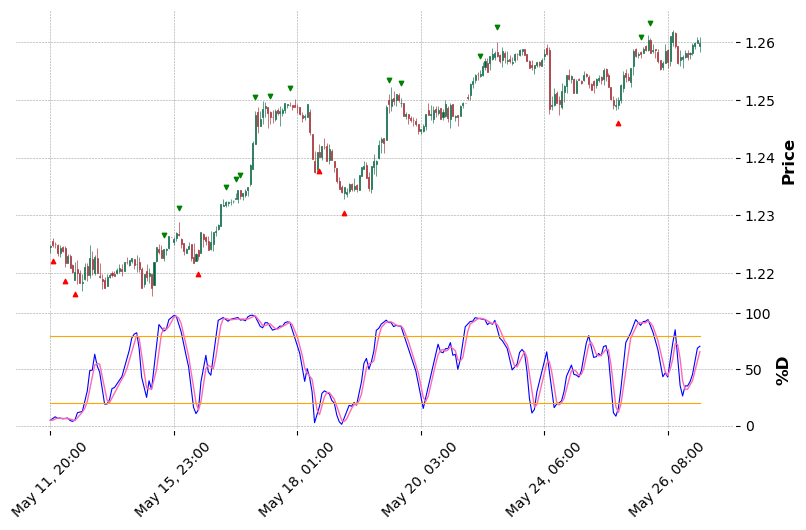

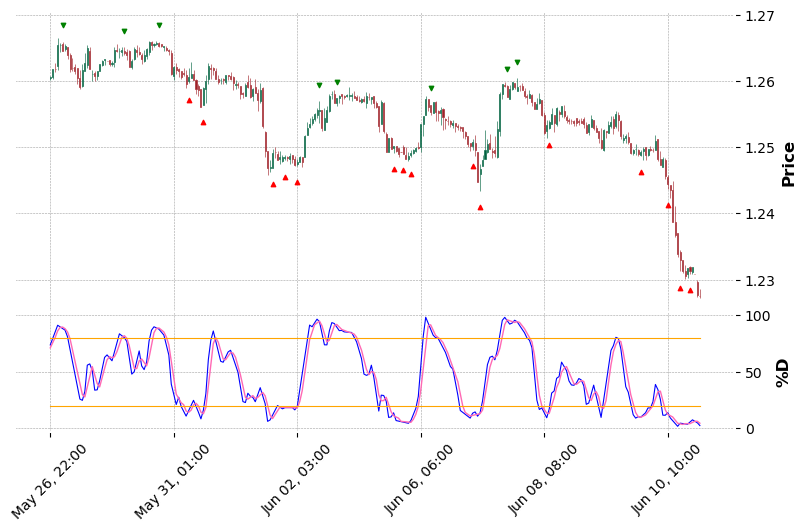

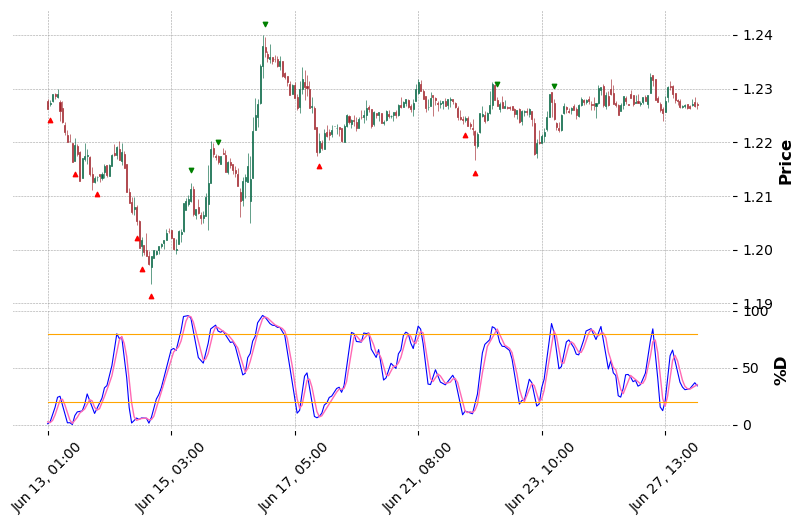

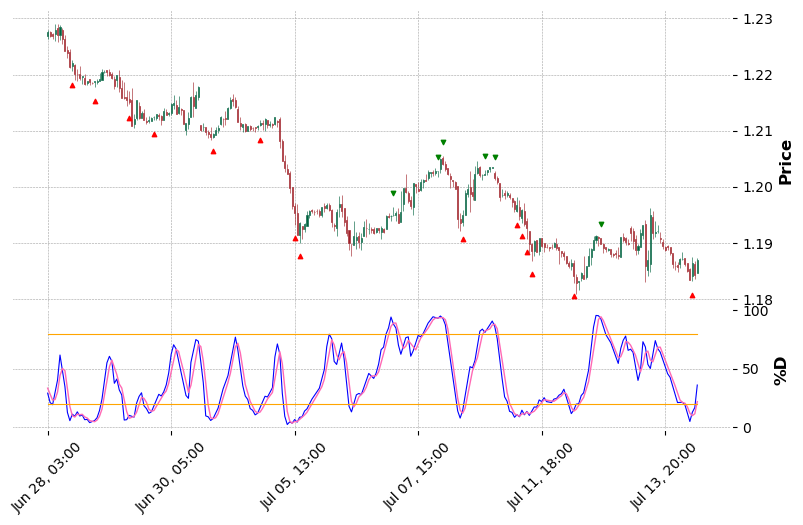

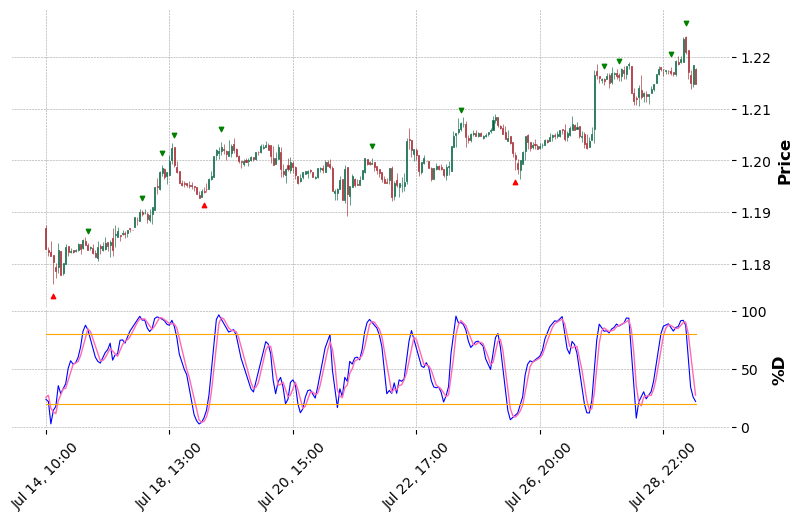

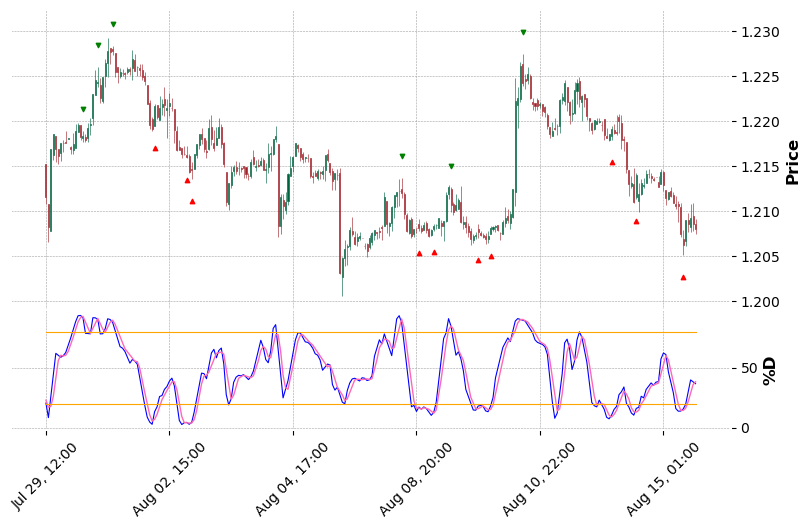

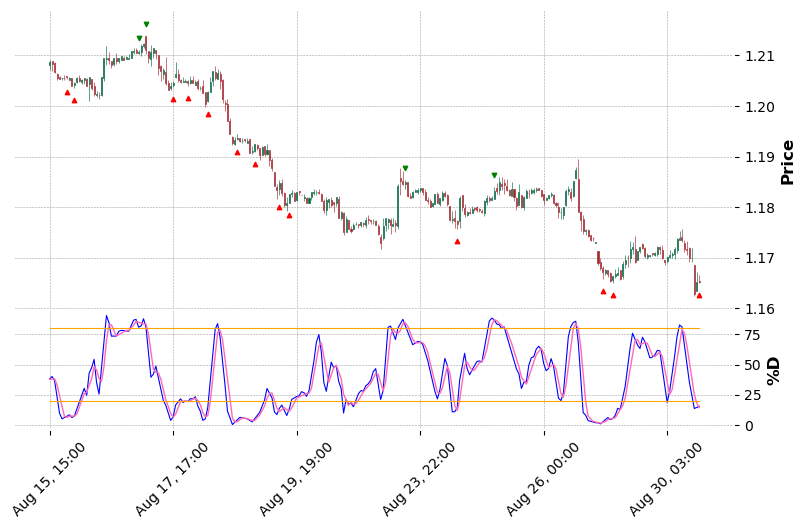

In [133]:
df_windows = np.linspace( 0, len(df), 20 )

for i in range(len(df_windows) - 1):
    start, end = int(df_windows[i]), int(df_windows[i+1])
    stoch_info_plots = stoch_plot(df, start, end)

    mpf.plot(df.iloc[start:end], type='candle', style='charles',
         addplot=stoch_info_plots,
         figsize=(10, 6))

In [125]:
def find_peak(price, i, order):
    
    max_idx = list(argrelextrema(price.values[:i], np.greater, order=order)[0])
    min_idx = list(argrelextrema(price.values[:i], np.less, order=order)[0])

    idx = max_idx + min_idx + [len(price.values[:i]) - 1]
    idx.sort()
    current_idx = idx[-6:]
    
    start = min(current_idx)
    end = max(current_idx)
    
    current_pat = price.values[current_idx]
    
    return current_pat, current_idx, start, end

In [126]:
def find_trend(current_pat):
    
    if current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down'

    elif current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up end'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down end'

    else:
        return False

up


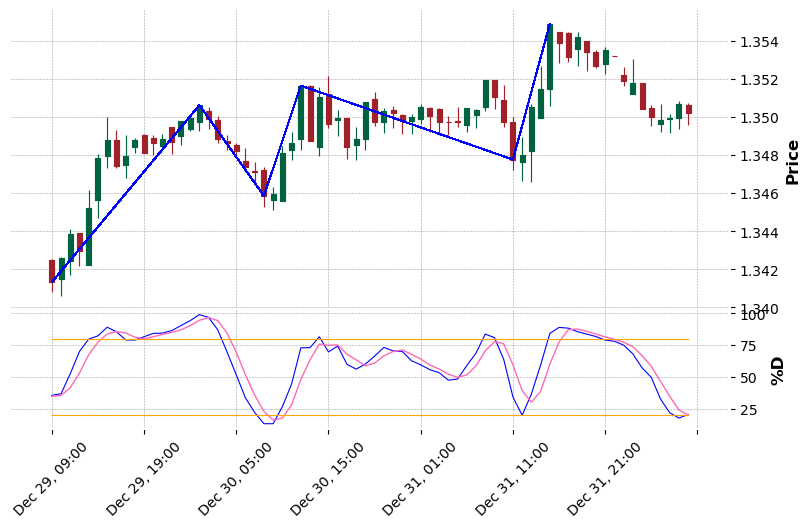

up


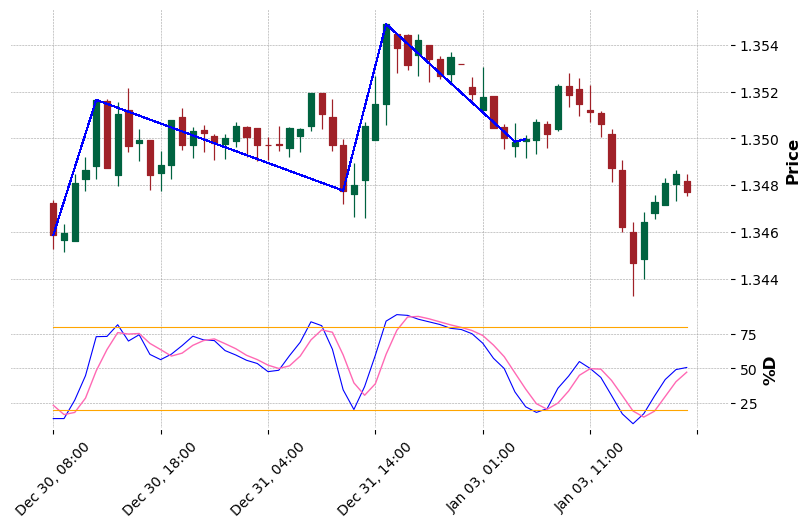

up


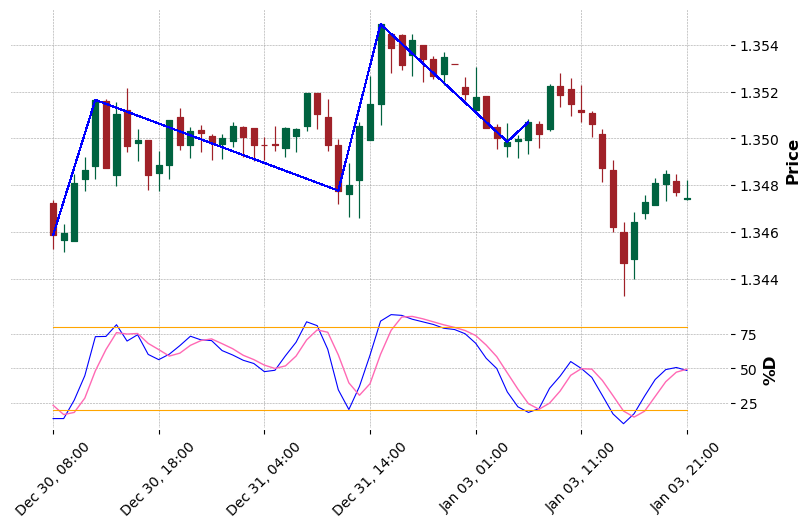

up


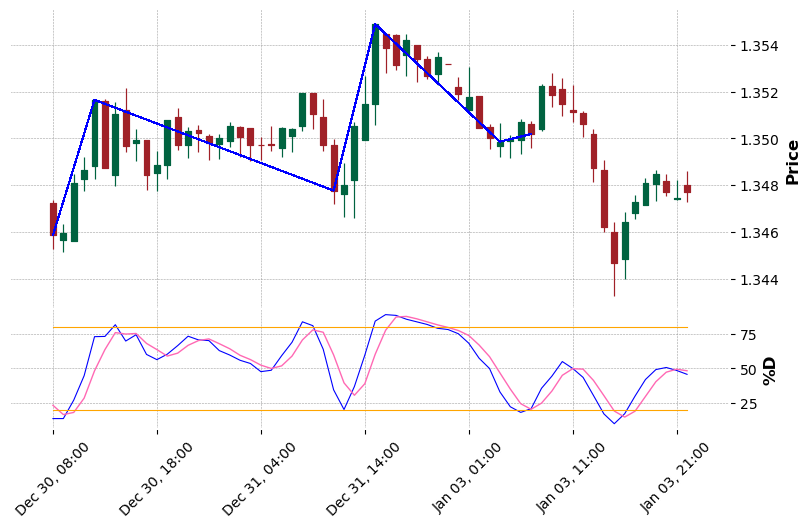

up


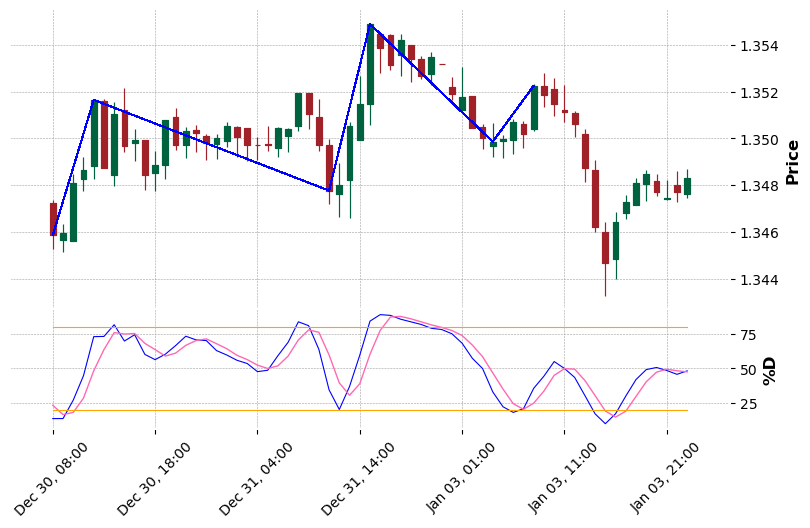

up


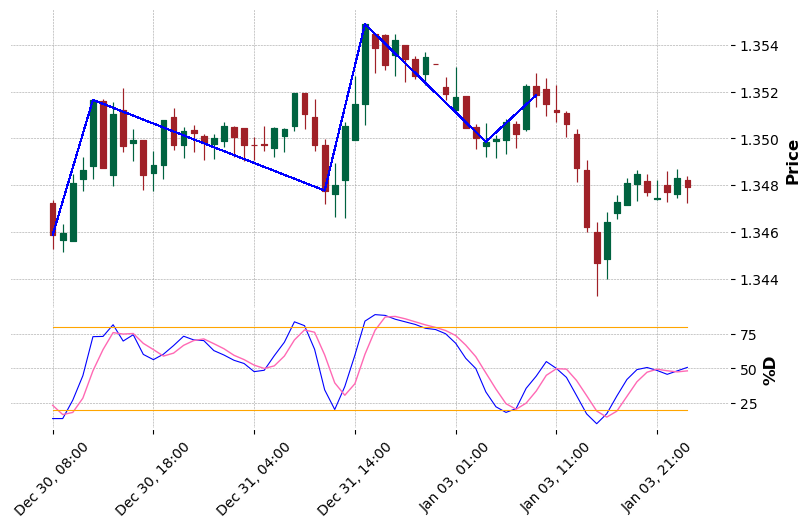

up


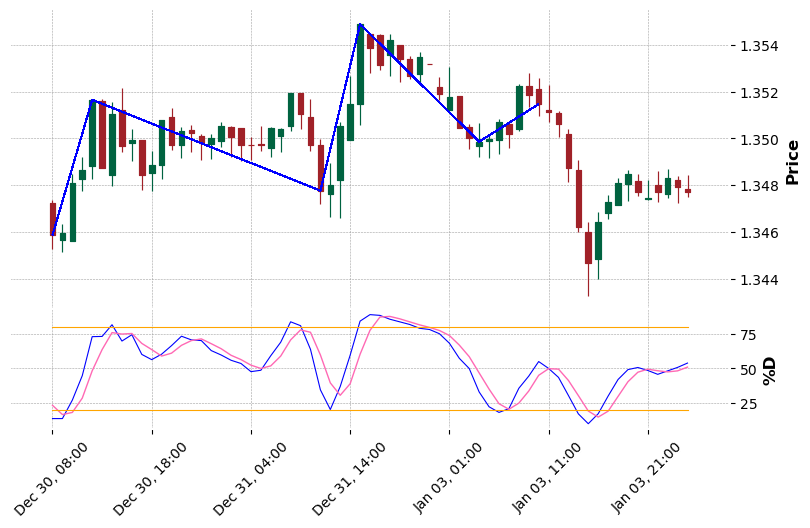

up


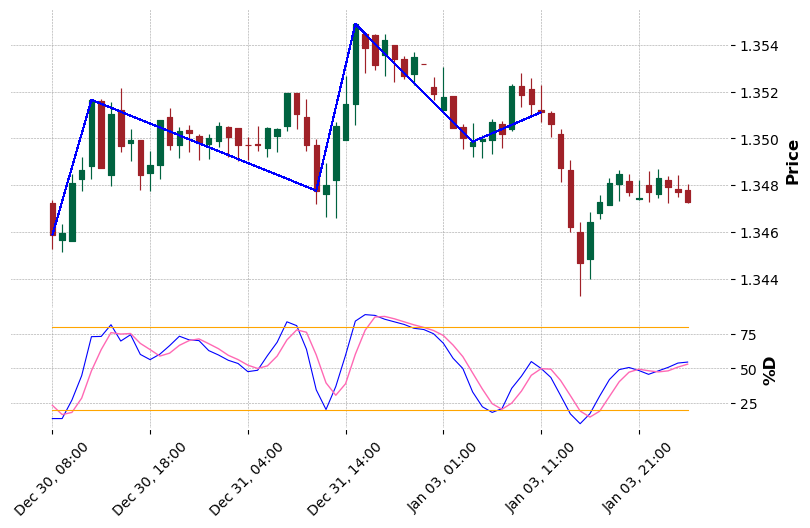

up


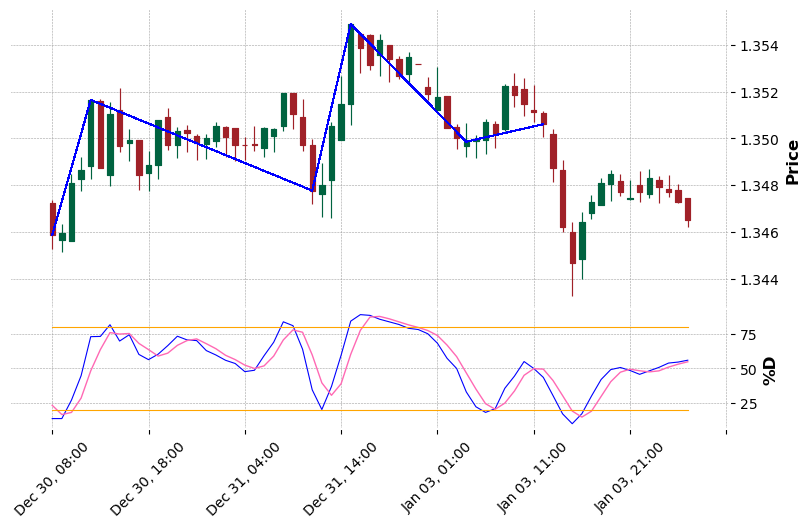

In [144]:
price = df['close'].copy()
for i in range(600, 1000):
    
     current_pat, current_idx, start, end = find_peak(price, i, 10)
     peak_lines = [(price.index[current_idx[i]], current_pat[i]) for i in range(len(current_pat))]
     trend = find_trend(current_pat) # , err_allowed)
     # print(current_pat)
    
     if trend is not False:
          print(trend)
          mpf.plot(df.iloc[start:i+15], type='candle', style='charles',
               addplot=stoch_plot(df, start, i+15, plot_cross=False),
               alines=dict(alines=peak_lines,colors=['blue'], linewidths=0.8),
               figsize=(10, 6))

In [145]:
# heatmap stoch K 10-20 and overbought/oversold 15-25 and 75-85 and ema 100, 150, 200
class Stoch_Experiment:
    def __init__(self, params):
        
        self.current_action = 'close'
        self.stoch = params['stoch']
        
        self.ema = params['ema']
        self.rr = params['rr']
        self.overbought = params['overbought']
        self.oversold = params['oversold']
        
        self.df = params['df']
        
        self.latest_sl = 0
        self.latest_tp = 0
        self.latest_entry = 0
        self.status = 'idle' # idle, overbought, oversold
        
    def get_df(self):
        return self.df
    
    def calLotSize(self, entry, exit):
        return abs(round(self.target_tp / (entry - exit)  , 2))
#         return abs(round(self.target_tp / (((entry - exit) / self.pip ) * self.pip_value ) , 2))

    def longCondition(self, row):
        if row['STOCHk_'+str(self.stoch)+'_3_3'] < self.oversold and self.status == 'idle':
            self.status = 'oversold'

        if  row['EMA_'+str(self.ema)] < row['low'] and self.status == 'oversold' and \
                row['STOCHd_'+str(self.stoch)+'_3_3'] > row['STOCHk_'+str(self.stoch)+'_3_3']:
                # row['prev_p'] < row['prev_k'] and 
                
            row['entries'] = True
            self.status = 'idle'
            self.current_action = 'long'
                
            self.latest_sl = row['low'] - row['ATRr_'+str(self.atr)]
            self.latest_tp = row['open'] + (self.rr * abs(row['open'] - self.latest_sl))
            row['lot_size'] = self.calLotSize(row['open'], self.latest_tp)
            self.latest_entry = row['open']
                
    def longResult(self, row):
        atr_price = self.latest_entry + abs(self.latest_entry - self.latest_sl)
        if row['low'] <= self.latest_sl:
            self.current_action = 'close'
            row['exits'] = True
            row['price_action'] = self.latest_sl
            row['lot_size'] = 0
                    
        elif row['high'] >= self.latest_tp:
            self.current_action = 'close'
            row['exits'] = True
            row['price_action'] = self.latest_tp
            row['lot_size'] = 0
                    
    def shortCondition(self, row):
        if row['STOCHk_'+str(self.stoch)+'_3_3'] > self.overbought and self.status == 'idle':
            self.status = 'overbought'

        if  row['EMA_'+str(self.ema)] > row['high'] and self.status == 'overbought' and \
                row['STOCHd_'+str(self.stoch)+'_3_3'] < row['STOCHk_'+str(self.stoch)+'_3_3']:
                # row['prev_p'] > row['prev_k'] and 
                    
            row['short_entries'] = True
            self.current_action = 'short'
            self.status = 'idle'
                
            self.latest_sl = row['high'] + row['ATRr_'+str(self.atr)]
            self.latest_tp = row['open'] - (self.rr * abs(row['open'] - self.latest_sl))
            row['lot_size'] = self.calLotSize(row['open'], self.latest_tp)
            self.latest_entry = row['open']
                
 
                                
    def createLongOrders(self, row):
        if self.current_action == 'close':
            self.longCondition(row)
            self.longResult(row)
        else:
            self.longResult(row)
        
        return row
                    
    def createStrategy(self):
        stoch_ema = ta.Strategy(
            name = 'Stochastic and EMA',
            description = 'Stochastic and EMA',
            ta = [
                {'kind': 'stoch', 'k': self.stoch},
                {'kind': 'ema', 'length': self.ema},
                {'kind': 'atr', 'length': self.atr}
            ]
        )
        self.df.ta.strategy(stoch_ema)
        
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['entries'] = False
        self.df['exits'] = False
        
        self.df['short_entries'] = False
        self.df['short_exits'] = False
        self.df['price_action'] = self.df['open']
        
        self.df['prev_d'] = self.df['STOCHd_'+str(self.stoch)+'_3_3'].shift(1)
        self.df['prev_k'] = self.df['STOCHk_'+str(self.stoch)+'_3_3'].shift(1)
        self.df['lot_size'] = np.nan
        
    def getLongOrders(self):
        self.createStrategy()
        self.df = self.df.apply(lambda row : self.createLongOrders(row), axis=1)
                                                                
        return self.df
    
        

Help on function tsignals in module pandas_ta.trend.tsignals:

tsignals(trend, asbool=None, trend_reset=0, trade_offset=None, drift=None, offset=None, **kwargs)
    Trend Signals
    
    Given a Trend, Trend Signals returns the Trend, Trades, Entries and Exits as
    boolean integers. When 'asbool=True', it returns Trends, Entries and Exits as
    boolean values which is helpful when combined with the vectorbt backtesting
    package.
    
    A Trend can be a simple as: 'close' > 'moving average' or something more complex
    whose values are boolean or integers (0 or 1).
    
    Examples:
    ta.tsignals(close > ta.sma(close, 50), asbool=False)
    ta.tsignals(ta.ema(close, 8) > ta.ema(close, 21), asbool=True)
    
    Source: Kevin Johnson
    
    Calculation:
        Default Inputs:
            asbool=False, trend_reset=0, trade_offset=0, drift=1
    
        trades = trends.diff().shift(trade_offset).fillna(0).astype(int)
        entries = (trades > 0).astype(int)
        exits

In [152]:
heatmap = vbt.plotting.Heatmap(
    data=[[1, 2, 1], [3, 4, 2]],
    x_labels=[1, 2, 3],
    y_labels=[1, 2]
)
heatmap.fig


FigureWidget({
    'data': [{'colorscale': [[0.0, '#0d0887'], [0.1111111111111111, '#46039f'],
               …